In [1]:
from representations import get_ffly_by_leg,get_reps,get_sprd_by_leg_n_width
from reference import CombinedMetaData, FutureMetaData, \
                      StrategyMetaData
from tqdm import tqdm
from randrun import sort_family
from pathlib import Path
from box import Box
import pandas as pd
import numpy as np
from functools import reduce
from datetime import datetime
from utils import *

In [2]:
path_to_data = '~/Desktop/algo/data'

In [3]:
refdata = CombinedMetaData.load('data/metadata.pickle')
get_reps(refdata) # maybe should be done once and saved
family = {rinst.code:cc.Instrument.fromReferenceData(rinst) for rinst in refdata.values()}
family = sort_family(family)
change_names(family)

In [4]:
list_w_dfs = get_data(path_to_data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 131/131 [07:26<00:00,  3.41s/it]


In [ ]:
#HI,
#THIS IS A NOTEBOOK THAT PRESENTS A TRADING STRATEGY USING SONIA STRATEGY PRODUCTS - BOX
#PLEASE NOTICE THAT THE TRADING EXAMPLE IS ONLY FOR SPECIFIC EXPIRATION CONTRACT (DEC24)

In [ ]:
#############################################################################################################################

In [ ]:
#############################################################################################################################

In [32]:
b = Box(name='Dec24', refdata=refdata)

In [33]:
b.reps

{'r1': [['615040908', 1], ['615040909', -1]],
 'r2': [['614870250', 1], ['614828915', -3]]}

In [34]:
#create codes_n_names:
codes_n_names = {}
for r in b.reps.values():
    codes_n_names[int(r[0][0])] = refdata[int(r[0][0])].description
    codes_n_names[int(r[1][0])] = refdata[int(r[1][0])].description

In [35]:
codes_n_names

{615040908: 'Dec24/Mar25--Mar25/Jun25',
 615040909: 'Mar25/Jun25--Jun25/Sep25',
 614870250: 'Dec24/Sep25',
 614828915: 'Mar25/Jun25'}

In [36]:
dct_for_data = get_ticks_by_codes(codes_n_names, list_w_dfs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.00it/s]


In [37]:
df_merged = reduce(lambda left,right: pd.merge(left,right,on=['TradeEvent_MarketTimestamp'], 
                                               how='outer'), list(dct_for_data.values()))
df_merged['timestamp']=df_merged['TradeEvent_MarketTimestamp'].apply(lambda x: str(datetime.fromtimestamp(x/1e6)))
# df_merged.dropna(inplace=True)
df_merged.sort_values(by = 'timestamp', inplace=True)

In [38]:
del dct_for_data

In [39]:
import gc
gc.collect()

174

In [40]:
df_merged['box_bid_sprd_fly'] = df_merged[f'TradeEvent_BestBid_Price_{codes_n_names[list(codes_n_names.keys())[0]]}'] -\
                                df_merged[f'TradeEvent_BestAsk_Price_{codes_n_names[list(codes_n_names.keys())[1]]}']


df_merged['box_ask_sprd_fly'] = df_merged[f'TradeEvent_BestAsk_Price_{codes_n_names[list(codes_n_names.keys())[0]]}'] -\
                                df_merged[f'TradeEvent_BestBid_Price_{codes_n_names[list(codes_n_names.keys())[1]]}']


df_merged['box_bid_9m_sprd'] = df_merged[f'TradeEvent_BestBid_Price_{codes_n_names[list(codes_n_names.keys())[2]]}']  -\
    3*df_merged[f'TradeEvent_BestAsk_Price_{codes_n_names[list(codes_n_names.keys())[3]]}']

df_merged['box_ask_9m_sprd'] = df_merged[f'TradeEvent_BestAsk_Price_{codes_n_names[list(codes_n_names.keys())[2]]}'] -\
    3*df_merged[f'TradeEvent_BestBid_Price_{codes_n_names[list(codes_n_names.keys())[3]]}']

In [41]:
df_merged['best_bid_box'] = df_merged[['box_bid_9m_sprd','box_bid_sprd_fly']].ffill().\
                                                                                        max(axis=1)
df_merged['best_ask_box'] = df_merged[['box_ask_9m_sprd','box_ask_sprd_fly']].ffill().\
                                                                                        min(axis=1)

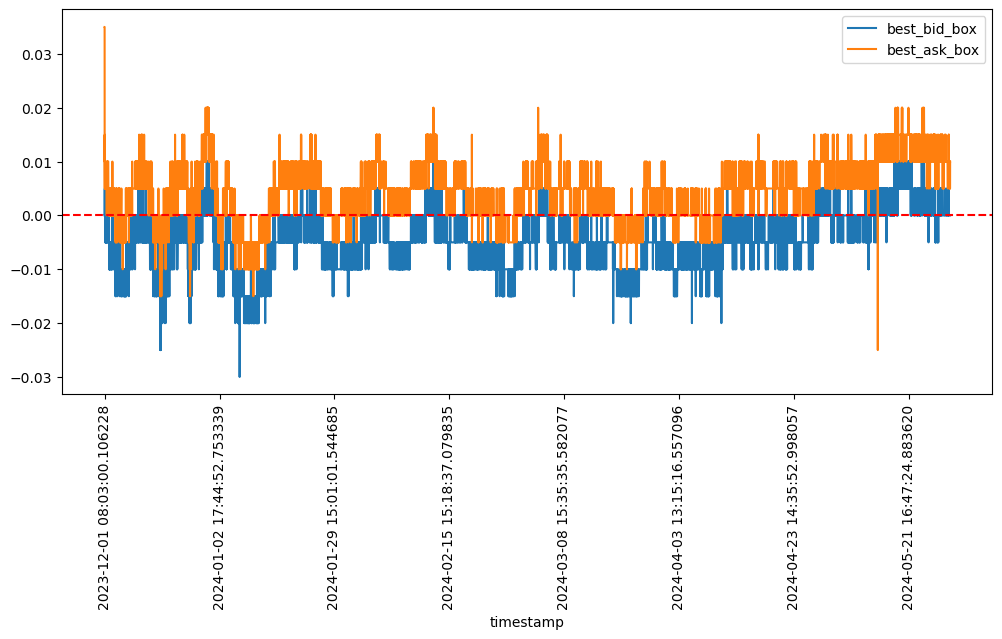

In [42]:
ax = df_merged.plot(x = 'timestamp', y = ['best_bid_box','best_ask_box'], rot = 90, figsize= (12,5))
ax.axhline(0, color="red", linestyle="--")

In [43]:
df_bb = df_merged[['best_bid_box','best_ask_box','timestamp']]
df_bb.reset_index(inplace=True)
df_bb = df_bb.drop_duplicates(subset=['best_bid_box','best_ask_box','timestamp'])
df_bb.drop(labels=df_bb[df_bb['best_bid_box']>=df_bb['best_ask_box']].index, axis=0, inplace=True)

In [44]:
pos_long=0
pos_short=0
longs = {}
shorts = {}
for tup in tqdm(df_bb.itertuples()):

    best_ask = round(tup.best_ask_box, 5)
    best_bid  = round(tup.best_bid_box, 5)
    
    if pos_long==0: 
        if best_ask <= -0.005: # half tick below theoretical mean
            last_price_l = best_ask
            longs[tup.timestamp] = {'buy':best_ask}#[1,best_ask, 'buy']
            pos_long+=1
            
    if pos_short==0:
        if best_bid >= 0.005:
            last_price_s = best_bid
            shorts[tup.timestamp] = {'sell':best_bid}#[1,best_bid, 'sell']
            pos_short+=1
            
    if pos_long>0 or pos_short>0:
        
        
        if pos_long>0:
            if last_price_l > best_ask:
                longs[tup.timestamp] = {'buy':best_ask}#[1, best_ask, 'buy']
                last_price_l = best_ask
                pos_long+=1
            elif best_bid > last_price_l:
                longs[tup.timestamp] = {'sell':best_bid}#[1, best_bid, 'sell']
                last_price_l = best_bid
                pos_long-=1
            
        elif pos_short>0:
            if last_price_s > best_ask:
                shorts[tup.timestamp] = {'buy':best_ask}#[1,best_ask, 'buy']
                pos_short-=1
                last_price_s = best_ask
                
            elif last_price_s < best_bid:
                shorts[tup.timestamp] = {'sell':best_bid}#[1,best_bid, 'sell']
                last_price_s = best_bid
                pos_short+=1

14434265it [00:14, 993992.76it/s] 


In [45]:
buys = []
sells = []
for t in shorts: 
    if 'buy' in shorts[t]:
        buys.append(shorts[t]['buy'])
    else:
        sells.append(shorts[t]['sell'])
try:
    print(sum(np.array(sells[:len(buys)]) - np.array(buys)))
except:
    print(sum(np.array(sells) - np.array(buys[:len(sells)])))

0.08500000000000002


In [46]:
print(len(buys),len(sells)) # THE DIFF IS AMOUNT OF OPEN ORDERS

18 19


In [48]:
print(len(buys),len(sells)) # THE DIFF IS AMOUNT OF OPEN ORDERS

23 23


In [57]:
buys = []
sells = []
for t in longs: 
    if 'buy' in longs[t]:
        buys.append(longs[t]['buy'])
    else:
        sells.append(longs[t]['sell'])
try:
    print(sum(-np.array(buys) + np.array(sells[:len(buys)])))
except:
    print(sum(-np.array(buys[:len(sells)]) + np.array(sells)))

0.11500000000000002


In [49]:
shorts

{'2023-12-01 08:03:00.107491': {'sell': 0.005},
 '2023-12-01 12:55:21.748705': {'buy': 0.0},
 '2023-12-08 13:01:00.734110': {'sell': 0.005},
 '2023-12-12 13:16:01.401225': {'buy': 0.0},
 '2023-12-20 09:30:20.131875': {'sell': 0.005},
 '2023-12-20 09:30:54.993635': {'buy': 0.0},
 '2023-12-21 18:24:30.213988': {'sell': 0.005},
 '2023-12-27 16:06:23.634615': {'sell': 0.01},
 '2023-12-28 18:22:40.901765': {'buy': 0.005},
 '2024-01-02 10:38:27.466645': {'buy': 0.0},
 '2024-01-22 10:08:09.218504': {'sell': 0.005},
 '2024-01-25 15:57:05.797187': {'buy': 0.0},
 '2024-02-02 16:29:32.532249': {'sell': 0.005},
 '2024-02-05 15:26:16.808462': {'buy': 0.0},
 '2024-02-13 09:30:12.714542': {'sell': 0.005},
 '2024-02-13 17:33:21.023640': {'sell': 0.01},
 '2024-02-13 18:51:01.687678': {'buy': 0.005},
 '2024-02-15 11:02:43.078076': {'buy': 0.0},
 '2024-02-19 13:06:28.038050': {'sell': 0.005},
 '2024-02-20 11:17:25.532171': {'buy': 0.0},
 '2024-03-05 11:02:00.465620': {'sell': 0.005},
 '2024-03-06 16:44:4

In [167]:
longs

{'2023-12-11 14:29:38.096022': {'buy': -0.005},
 '2023-12-12 14:17:40.486939': {'sell': -0.0},
 '2023-12-12 15:54:04.487034': {'buy': -0.005},
 '2023-12-13 11:28:06.280591': {'sell': 0.0},
 '2023-12-19 18:49:58.465360': {'buy': -0.005},
 '2023-12-20 09:30:08.745951': {'sell': 0.0},
 '2023-12-20 09:30:25.571422': {'buy': -0.005},
 '2023-12-20 09:33:56.625163': {'buy': -0.01},
 '2023-12-20 09:42:36.990495': {'buy': -0.015},
 '2023-12-20 09:46:23.005559': {'buy': -0.02},
 '2023-12-20 09:56:02.509651': {'buy': -0.025},
 '2023-12-20 10:28:50.293171': {'sell': -0.02},
 '2023-12-20 12:38:14.219933': {'sell': -0.015},
 '2023-12-20 12:48:42.511436': {'sell': -0.01},
 '2023-12-20 15:56:53.613438': {'buy': -0.015},
 '2023-12-20 16:56:52.313135': {'buy': -0.02},
 '2023-12-20 17:27:56.975277': {'sell': -0.015},
 '2023-12-20 18:56:52.495586': {'buy': -0.02},
 '2023-12-20 19:48:03.430874': {'buy': -0.025},
 '2023-12-21 10:35:11.406358': {'buy': -0.03},
 '2023-12-21 17:10:54.044795': {'sell': -0.025},

In [ ]:
#####################################################################################################

In [ ]:
#####################################################################################################

In [ ]:
###LIMIT ORDERS-----^ instead of MARKET###